Model: "Seq2Seq-Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Decoder-Input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 Decoder-Embedding (Embeddi  (None, None, 30)             30000     ['Decoder-Input[0][0]']       
 ng)                                                                                              
                                                                                                  
 Encoder-Input (InputLayer)  [(None, 20)]                 0         []                            
                                                                                                  
 Decoder-Batchnorm-1 (Batch  (None, None, 30)             120       ['Decoder-Embeddin

None


Epoch 1/10
80/80 [==============================] - 8s 31ms/step - loss: 6.9293 - accuracy: 0.0017 - val_loss: 6.9074 - val_accuracy: 0.0017
Epoch 2/10
80/80 [==============================] - 1s 14ms/step - loss: 6.7308 - accuracy: 0.0129 - val_loss: 6.9068 - val_accuracy: 0.0028
Epoch 3/10
80/80 [==============================] - 1s 14ms/step - loss: 6.5165 - accuracy: 0.0492 - val_loss: 6.9063 - val_accuracy: 0.0017
Epoch 4/10
80/80 [==============================] - 1s 14ms/step - loss: 6.2528 - accuracy: 0.0946 - val_loss: 6.9084 - val_accuracy: 0.0039
Epoch 5/10
80/80 [==============================] - 1s 14ms/step - loss: 5.9370 - accuracy: 0.1400 - val_loss: 6.9212 - val_accuracy: 0.0039
Epoch 6/10
80/80 [==============================] - 1s 14ms/step - loss: 5.5865 - accuracy: 0.1713 - val_loss: 6.9645 - val_accuracy: 0.0011
Epoch 7/10
80/80 [==============================] - 1s 14ms/step - loss: 5.2207 - accuracy: 0.2069 - val_loss: 7.0863 - val_accuracy: 5.5556e-04
Epoch 8/1

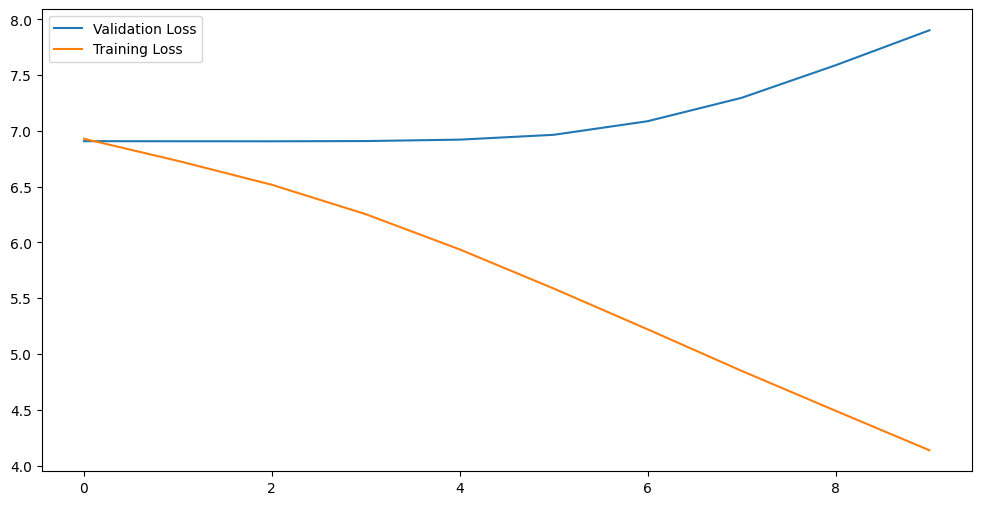

Model: "Encoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder-Input (InputLayer)  [(None, 20)]              0         
                                                                 
 Encoder-Embedding (Embeddi  (None, 20, 30)            60000     
 ng)                                                             
                                                                 
 Encoder-Batchnorm-1 (Batch  (None, 20, 30)            120       
 Normalization)                                                  
                                                                 
 Encoder-Last-GRU (GRU)      [(None, 30),              5580      
                              (None, 30)]                        
                                                                 
Total params: 65700 (256.64 KB)
Trainable params: 65640 (256.41 KB)
Non-trainable params: 60 (240.00 Byte)
____________

ValueError: Data cardinality is ambiguous:
  x sizes: 10, 1
Make sure all arrays contain the same number of samples.

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from shutil import rmtree
import tensorflow  as tf
from tensorflow.keras.layers import Lambda, Dense, Input, Embedding, BatchNormalization, GRU
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model



class Seq2Seq_Model:
    def __init__(self, src_vocab_size, src_seq_len, tgt_vocab_size, tgt_seq_len, workspace_dir):
         self.num_input_tokens = src_vocab_size
         self.input_seq_len = src_seq_len
         self.latent_dim = 30 
         self.num_output_tokens = tgt_vocab_size
         self.out_seq_len = tgt_seq_len
         self.workspace = workspace_dir 
         self.output_dir = self.workspace + os.sep + "output"
         self.log_dir = self.workspace + os.sep + "log"
        
         os.makedirs (self.workspace, exist_ok=True)
         os.makedirs (self.output_dir, exist_ok=True)
         os.makedirs (self.log_dir, exist_ok=True)
        
         self.model = self.__get_model__()

    

    def __get_model__(self, ):
        
        self.enc_inp = Input(shape = (self.input_seq_len,), name = "Encoder-Input")
        embd = Embedding(self.num_input_tokens, self.latent_dim, name='Encoder-Embedding', mask_zero=False)
        embd_outp = embd(self.enc_inp)

        x = BatchNormalization(name='Encoder-Batchnorm-1')(embd_outp)
        _, state_h = GRU(self.latent_dim, return_state=True, name='Encoder-Last-GRU')(x)

        self.enc_model = Model(inputs=self.enc_inp, outputs=state_h, name='Encoder-Model')
        self.enc_outp = self.enc_model(self.enc_inp)

        # get the decoder 
        self.dec_inp = Input(shape=(None,), name='Decoder-Input')
        dec_emb = Embedding(self.num_output_tokens, self.latent_dim,
                            name='Decoder-Embedding', mask_zero=False)(self.dec_inp)
        
        dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)
        decoder_gru = GRU(self.latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
        decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=self.enc_outp)

        x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)
        dec_dense = Dense(self.num_output_tokens, activation='softmax', name='Final-Output-Dense')
        self.dec_outp = dec_dense(x)

        model_inp = [self.enc_inp, self.dec_inp]
        self.model = Model(model_inp, self.dec_outp,name="Seq2Seq-Model")
     
        return self.model  

    def fit_model(self, input_vecs, output_vecs, nepochs):

         batch_size = 10 
         input_data = [input_vecs,  output_vecs[:, :-1]]
         output_data = output_vecs[:, 1:]

         self.model.compile(optimizer=optimizers.Nadam(lr=0.001),
            loss='sparse_categorical_crossentropy', metrics=['accuracy'])

         model_checkpoint = ModelCheckpoint(self.output_dir + os.sep +  'model.hdf5',
                                           monitor='val_loss', save_best_only=True, period=1)

         csv_logger = CSVLogger(self.log_dir + os.sep + 'history.csv')
         tb_dir =  self.log_dir + os.sep + "tensorboard"

         if os.path.isfile(tb_dir):
            rmtree(tb_dir)

         tensorboard = TensorBoard(log_dir = tb_dir,
            histogram_freq =10, batch_size = batch_size,
            write_graph =True, write_grads =False, write_images =False,
            embeddings_freq =0, embeddings_layer_names=None, embeddings_metadata= None,
            embeddings_data =None)

         history = self.model.fit(input_data, np.expand_dims(output_data, -1),
                  batch_size = batch_size,
                  epochs = nepochs , validation_split = 0.2,
                  callbacks=[csv_logger, model_checkpoint, tensorboard])

         return history 




def inference (model):

    latent_dim = model.get_layer('Decoder-Embedding').output_shape[-1]
        
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)
        
    gru_inference_state_input = Input(shape=(latent_dim,),
       name='hidden_state_input')
 
    gru_out, gru_state_out = model.get_layer('Decoder-GRU') \
       ([dec_bn, gru_inference_state_input])

    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(gru_out)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input],
                                   [dense_out, gru_state_out],name="Decoder-Model")

    return decoder_model 
    

def predict_seq (encoder_model, decoder_model, X, X0):

    max_target_seq = 20
    start_token = 0 
    end_token = 3
   
    embd_vec = encoder_model.predict(X)
    print("embd_vec",embd_vec.shape)
    
    latent_dim = 30

    decoded_sentence = []
    stop_condition = False
    state_value = embd_vec

    # Encode the input as state vectors.
    states_value = encoder_model.predict(X)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1000))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 1] = 1.0
    embd_vec = target_seq 
    

    while not stop_condition:
         #state_value = embd_vec
         print("pp",state_value.shape)
         preds, st = decoder_model.predict([state_value, embd_vec])

         # We are going to ignore indices 0 (padding) and indices 1 (unknown)
         # Argmax will return the integer index corresponding to the
         #  prediction + 2 b/c we chopped off first two
          
         pred_idx = np.argmax(preds[:, :, 2:]) + 2
         print("pred_idx",pred_idx)
         if pred_idx== end_token  or len(decoded_sentence) >=  max_target_seq:
               stop_condition = True
               break
         decoded_sentence.append(pred_idx)

         # update the decoder for the next word
         embd_vec = st
         state_value = np.array(pred_idx).reshape(1, 1)

    return decoded_sentence 




def get_data (src_vocab_size, src_seq_len, tgt_vocab_size, tgt_seq_len):
     
     np.random.seed (seed=202)
     num_data = 1000 
     x = np.random.randint (0, src_vocab_size, [num_data, src_seq_len])
     y = np.random.randint (0, tgt_vocab_size, [num_data, tgt_seq_len])
     return x, y


def plot_history (history):

    fig, axs = plt.subplots (1,1,figsize=(12,6))
    axs.plot (history.history['val_loss'],label='Validation Loss')
    axs.plot (history.history['loss'],label='Training Loss')
    axs.legend()
    plt.show()
    



if __name__ == "__main__":

    src_vocab_size = 2000
    tgt_vocab_size = 1000
    src_seq_len = 20
    tgt_seq_len = 10
    num_data  = 1000

    Seq2Seq = Seq2Seq_Model (src_vocab_size, src_seq_len, tgt_vocab_size, tgt_seq_len,"results")
    
    x_train, y_train = get_data (src_vocab_size, src_seq_len, tgt_vocab_size, tgt_seq_len)

    print(Seq2Seq.model.summary())

    hist = Seq2Seq.fit_model(x_train, y_train,10)

    plot_history (hist)


    encd_model = Seq2Seq.enc_model
    print(encd_model.summary())

    
    decd_model = inference (Seq2Seq.model)

    #print(decd_model.summary())

    X = x_train[10:20,:]
    #print("X=",X.shape)
    y = predict_seq (encd_model, decd_model, X,x_train[1:])
    print(y)

